### Imports

In [68]:
import pandas as pd
import numpy as np
import statistics
import seaborn as sns
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import datetime
from imblearn.over_sampling import SMOTE
from zipfile import ZipFile

#Stats Imports
from scipy import stats

import wrangle

### Certain configs for visualizations

In [2]:
import matplotlib.style as style
style.use('seaborn-colorblind')

/var/folders/h6/xxqcvddd61v8kq3bhvkfyqzw0000gn/T/ipykernel_34255/29349232.py:2: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  style.use('seaborn-colorblind')


### Acquire datasets

In [3]:
test, df = wrangle.acquire_fraud('cc_fraud.zip')

In [4]:
test.shape,df.shape

((555719, 23), (1296675, 23))

### Clean and Prep

In [5]:
df = wrangle.prep(df)
test = wrangle.prep(test)

In [6]:
df.head()

,merchant,category,amt,gender,zip,city_pop,job,merch_lat,merch_long,is_fraud,age,dayofweek,hourofday,age_group
trans_date_trans_time,,,,,,,,,,,,,,
2019-01-01 00:00:18,"fraud_Rippin, Kub and Mann",misc_net,4.97,F,28654,3495,"Psychologist, counselling",36.011293,-82.048315,0,30,Tuesday,0,Young_Adult
2019-01-01 00:00:44,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.23,F,99160,149,Special educational needs teacher,49.159047,-118.186462,0,40,Tuesday,0,Adult
2019-01-01 00:00:51,fraud_Lind-Buckridge,entertainment,220.11,M,83252,4154,Nature conservation officer,43.150704,-112.154481,0,56,Tuesday,0,Mid_Age
2019-01-01 00:01:16,"fraud_Kutch, Hermiston and Farrell",gas_transport,45.00,M,59632,1939,Patent attorney,47.034331,-112.561071,0,52,Tuesday,0,Early_Mid_Age
2019-01-01 00:03:06,fraud_Keeling-Crist,misc_pos,41.96,M,24433,99,Dance movement psychotherapist,38.674999,-78.632459,0,32,Tuesday,0,Young_Adult


### Define target ('is_fraud') versus the rest of the features

In [7]:
target,features = wrangle.get_target_and_features(df)
print(target)
print('______')
print(features)

is_fraud
______
['merchant', 'category', 'amt', 'gender', 'zip', 'city_pop', 'job', 'merch_lat', 'merch_long', 'age', 'dayofweek', 'hourofday', 'age_group']


### Split the training data further (into Train and Validate)

In [8]:
x_train,x_validate,y_train,y_validate = wrangle.train_val(df)

In [9]:
x_train.sample()

,merchant,category,amt,gender,zip,city_pop,job,merch_lat,merch_long,age,dayofweek,hourofday,age_group
trans_date_trans_time,,,,,,,,,,,,,
2019-05-19 02:36:28,fraud_Harris Inc,gas_transport,83.17,M,99033,895,Clothing/textile technologist,48.171668,-116.712809,19,Sunday,2,Youth


In [10]:
y_train.sample()

trans_date_trans_time
2019-03-18 21:24:16    0
Name: is_fraud, dtype: int64

### Break the TEST dataset into x and y sets

In [11]:
x_test,y_test = wrangle.test_df_x_y_split(test)

In [12]:
x_test.sample()

,merchant,category,amt,gender,zip,city_pop,job,merch_lat,merch_long,age,dayofweek,hourofday,age_group
trans_date_trans_time,,,,,,,,,,,,,
2020-10-11 16:29:03,fraud_Crooks and Sons,personal_care,80.41,M,45051,177,Exhibition designer,38.10129,-84.601272,46,Sunday,16,Early_Mid_Age


In [13]:
y_test.sample()

trans_date_trans_time
2020-08-05 16:57:39    0
Name: is_fraud, dtype: int64

# Begin EDA (using the original DF, which includes train and validate data)

In [14]:
# df.isna().sum()
# There are NO nulls

In [63]:
# df.info()

### First of all...CLASS IMBALANCE?

In [15]:
df.is_fraud.value_counts()

is_fraud
0    1289169
1       7506
Name: count, dtype: int64

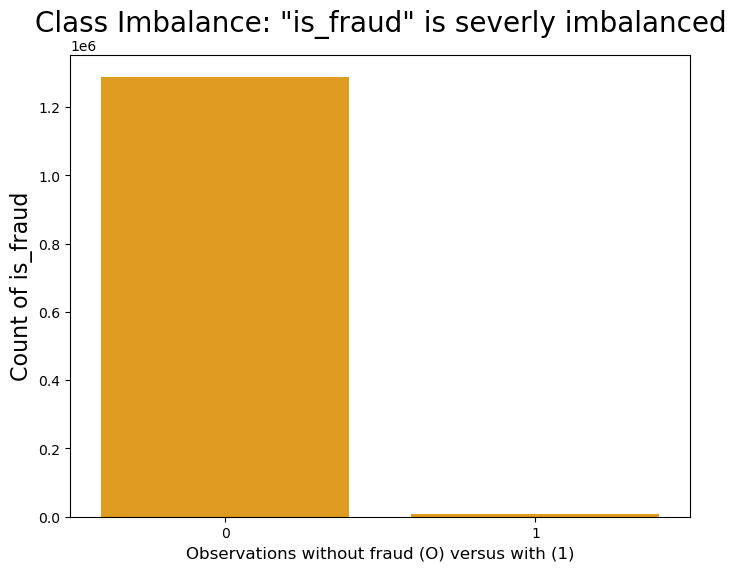

In [16]:
plt.figure(figsize = (8, 6))
ax = sns.countplot(x=df['is_fraud'],color='orange')
ax.set_xlabel(xlabel = 'Observations without fraud (O) versus with (1)', fontsize = 12)
ax.set_ylabel(ylabel = 'Count of is_fraud', fontsize = 16)
ax.set_title(label = 'Class Imbalance: "is_fraud" is severly imbalanced', fontsize = 20)

plt.show()

### Amount?

In [17]:
amount_df = df.copy()
amount_df.sample()

,merchant,category,amt,gender,zip,city_pop,job,merch_lat,merch_long,is_fraud,age,dayofweek,hourofday,age_group
trans_date_trans_time,,,,,,,,,,,,,,
2019-08-25 02:34:44,"fraud_Tillman, Dickinson and Labadie",gas_transport,67.67,M,71762,2501,Financial adviser,32.954163,-93.370561,0,33,Sunday,2,Young_Adult


In [18]:
amount_df.amt.min(),amount_df.amt.max()

(1.0, 28948.9)

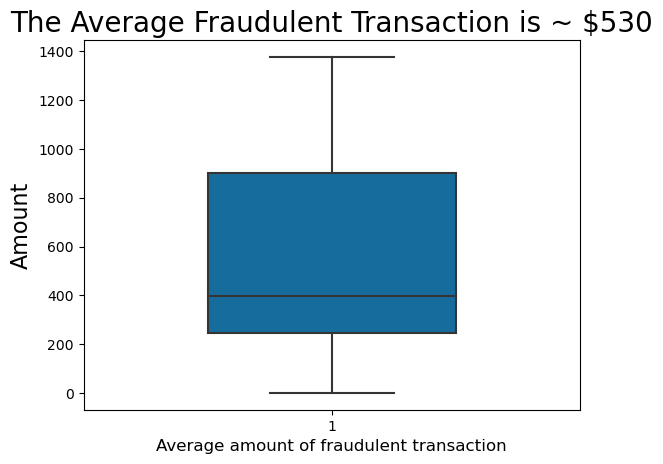

In [19]:
ax = sns.boxplot(data=amount_df[amount_df['is_fraud']==1],y=amount_df[amount_df['is_fraud']==1].amt,x=amount_df[amount_df['is_fraud']==1].is_fraud,width=.5)
ax.set_xlabel(xlabel = 'Average amount of fraudulent transaction', fontsize = 12)
ax.set_ylabel(ylabel = 'Amount', fontsize = 16)
ax.set_title(label = 'The Average Fraudulent Transaction is ~ $530', fontsize = 20)
plt.show()

In [20]:
df[df['is_fraud']==1].amt.min(),df[df['is_fraud']==1].amt.max(),df[df['is_fraud']==1].amt.mean()

(1.06, 1376.04, 531.3200919264589)

In [21]:
np.arange(0,1200,50)

array([   0,   50,  100,  150,  200,  250,  300,  350,  400,  450,  500,
        550,  600,  650,  700,  750,  800,  850,  900,  950, 1000, 1050,
       1100, 1150])

In [22]:
bins = [   0,   50,  100,  150,  200,  250,  300,  350,  400,  450,  500,
        550,  600,  650,  700,  750,  800,  850,  900,  950, 1000, 1050,
       1100, 1150,35000]

In [23]:
labels = ['0_50','50_100','100_150','150_200','200_250','250_300','300_350','350_400','400_450','450_500','500_550','550_600','600_650','650_700','700_750','750_800','800_850','850_900','900_950','950_1000','1000_1050','1050_1100','1100_1150','over_1150']

In [24]:
# df['age_group'] = pd.cut(df['age'],[0,25,35,45,55,65,75,100], labels= ['Youth','Young_Adult','Adult','Early_Mid_Age','Mid_Age','Retirement_Age','Older_Person'],right=False)

amount_df['amt_bin'] = pd.cut(amount_df['amt'],bins=bins,labels=labels, right = False)
amount_df.sample(2)

,merchant,category,amt,gender,zip,city_pop,job,merch_lat,merch_long,is_fraud,age,dayofweek,hourofday,age_group,amt_bin
trans_date_trans_time,,,,,,,,,,,,,,,
2019-08-22 15:47:46,fraud_Bogisich-Weimann,kids_pets,150.13,F,49854,6469,Trade mark attorney,46.594221,-86.887160,0,40,Thursday,15,Adult,150_200
2020-05-26 21:57:12,"fraud_Swaniawski, Lowe and Robel",shopping_pos,426.09,F,10039,1577385,Herbalist,41.481683,-73.086737,0,38,Tuesday,21,Adult,400_450


In [25]:
amount_df[amount_df['is_fraud']==1].amt_bin.value_counts()

amt_bin
0_50         1607
300_350       974
250_300       701
900_950       487
950_1000      456
850_900       450
750_800       411
800_850       381
1000_1050     364
1050_1100     282
700_750       252
350_400       186
1100_1150     165
100_150       145
over_1150     139
650_700       122
200_250        94
450_500        61
500_550        50
50_100         45
600_650        45
550_600        44
400_450        40
150_200         5
Name: count, dtype: int64

### Could there be a polynomial relationship in the amount bins?

In [26]:
# amount_df['amt_bin_fraud_ratio'] = 
# amount_df[amount_df['is_fraud']==1]['amt_bin']

# down_sample = amount_df.sample(10_000)

In [27]:
# down_sample.head(1)

In [28]:
# down_sample.amt.groupby([down_sample['amt_bin'],down_sample['is_fraud'],down_sample['amt_bin']]).size().unstack(0)
# down_sample.groupby([down_sample['amt_bin'],down_sample['is_fraud']]).size().unstack(0)
amount_df.groupby([amount_df['amt_bin'],amount_df['is_fraud']]).size().unstack(0)

amt_bin,0_50,50_100,100_150,150_200,200_250,250_300,300_350,350_400,400_450,450_500,...,700_750,750_800,800_850,850_900,900_950,950_1000,1000_1050,1050_1100,1100_1150,over_1150
is_fraud,,,,,,,,,,,,,,,,,,,,,
0,670607,389469,127584,45283,23377,7459,4346,3094,2670,3297,...,662,585,450,398,363,296,253,234,210,2290
1,1607,45,145,5,94,701,974,186,40,61,...,252,411,381,450,487,456,364,282,165,139


In [29]:
# bins_fraud_breakdown = down_sample.groupby([down_sample['amt_bin'],down_sample['is_fraud']]).size().unstack(0)
# bins_fraud_sum = down_sample.groupby([down_sample['amt_bin'],down_sample['is_fraud']]).size().unstack(0).sum()
bins_fraud_breakdown = amount_df.groupby([amount_df['amt_bin'],amount_df['is_fraud']]).size().unstack(0)
bins_fraud_sum = amount_df.groupby([amount_df['amt_bin'],amount_df['is_fraud']]).size().unstack(0).sum()

In [30]:
percentage_df = bins_fraud_breakdown/bins_fraud_sum
percentage_df

amt_bin,0_50,50_100,100_150,150_200,200_250,250_300,300_350,350_400,400_450,450_500,...,700_750,750_800,800_850,850_900,900_950,950_1000,1000_1050,1050_1100,1100_1150,over_1150
is_fraud,,,,,,,,,,,,,,,,,,,,,
0,0.997609,0.999884,0.998865,0.99989,0.995995,0.914093,0.816917,0.943293,0.98524,0.981834,...,0.724289,0.587349,0.541516,0.46934,0.427059,0.393617,0.410049,0.453488,0.56,0.942775
1,0.002391,0.000116,0.001135,0.00011,0.004005,0.085907,0.183083,0.056707,0.01476,0.018166,...,0.275711,0.412651,0.458484,0.53066,0.572941,0.606383,0.589951,0.546512,0.44,0.057225


In [31]:
ratio_fraud = percentage_df[percentage_df.index == 1]
ratio_fraud

amt_bin,0_50,50_100,100_150,150_200,200_250,250_300,300_350,350_400,400_450,450_500,...,700_750,750_800,800_850,850_900,900_950,950_1000,1000_1050,1050_1100,1100_1150,over_1150
is_fraud,,,,,,,,,,,,,,,,,,,,,
1,0.002391,0.000116,0.001135,0.00011,0.004005,0.085907,0.183083,0.056707,0.01476,0.018166,...,0.275711,0.412651,0.458484,0.53066,0.572941,0.606383,0.589951,0.546512,0.44,0.057225


In [32]:
temp_df = pd.DataFrame(ratio_fraud.unstack(0)).droplevel(1)
# temp_df

In [33]:
fraud_ratio_per_bin_df = amount_df.merge(temp_df,on=['amt_bin']).rename(columns={0:'perc_fraud_in_bin'})

In [34]:
# fraud_ratio_per_bin_df = fraud_ratio_per_bin_df.rename(columns={0:'perc_fraud_in_bin'})

In [35]:
fraud_ratio_per_bin_df.sample()

,merchant,category,amt,gender,zip,city_pop,job,merch_lat,merch_long,is_fraud,age,dayofweek,hourofday,age_group,amt_bin,perc_fraud_in_bin
168959,fraud_Schulist Ltd,food_dining,19.3,F,27837,5903,Manufacturing systems engineer,34.842994,-77.277328,0,25,Tuesday,16,Young_Adult,0_50,0.002391


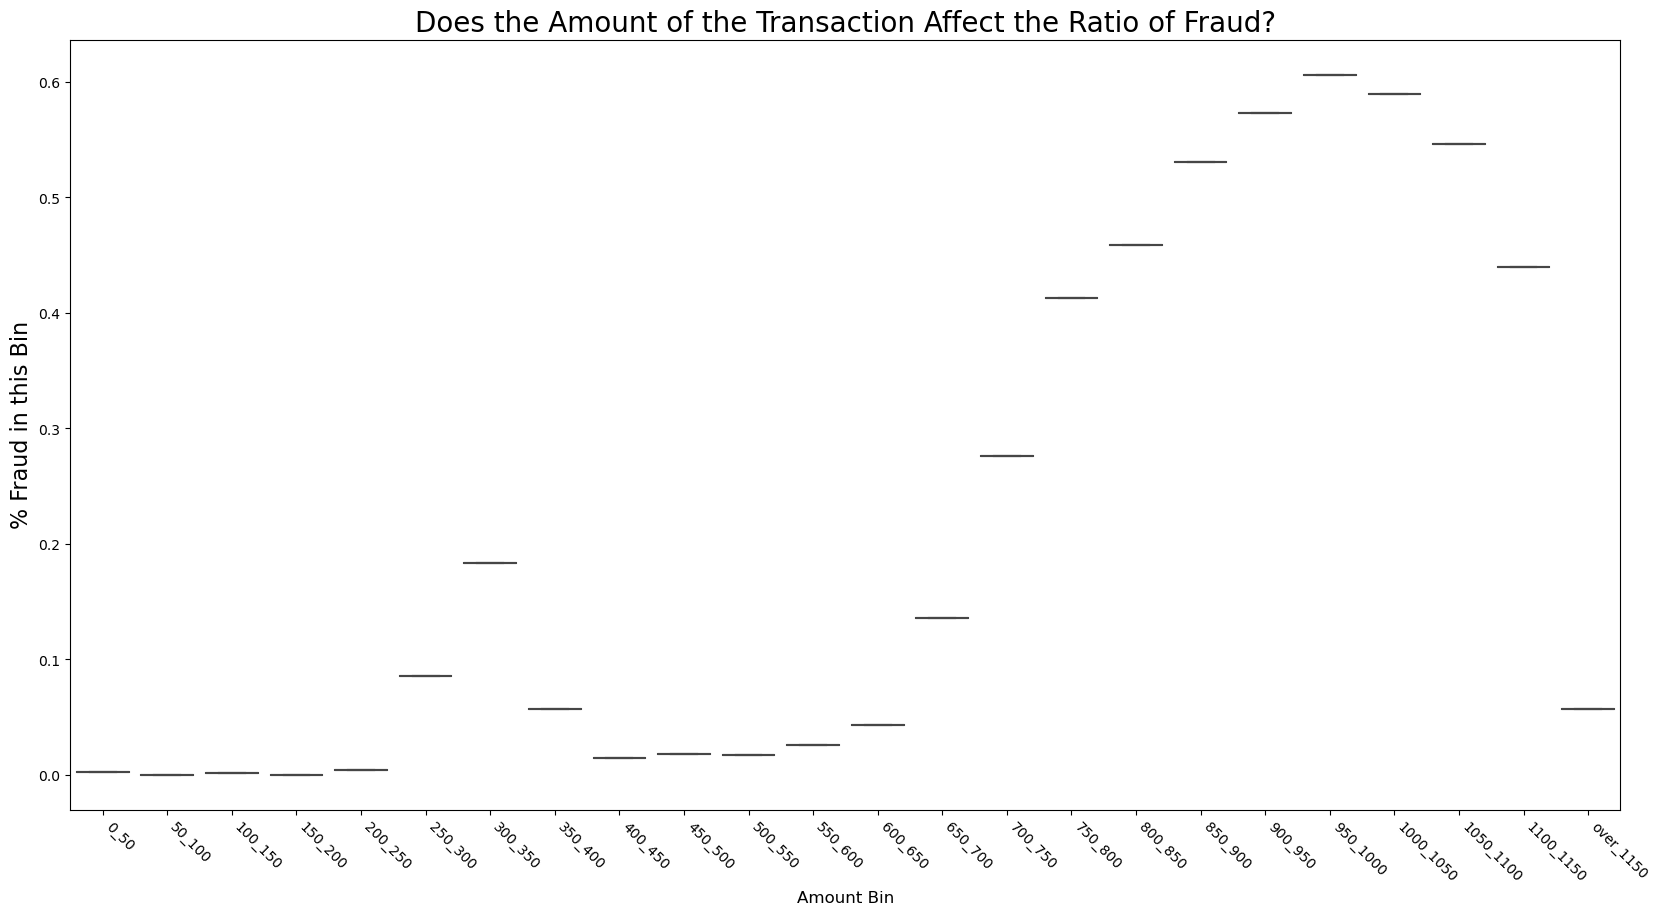

In [36]:
plt.figure(figsize = (20, 10))
ax = sns.boxplot(data=fraud_ratio_per_bin_df,y=fraud_ratio_per_bin_df.perc_fraud_in_bin,x=fraud_ratio_per_bin_df.amt_bin)
ax.set_xlabel(xlabel = 'Amount Bin', fontsize = 12)
ax.set_ylabel(ylabel = '% Fraud in this Bin', fontsize = 16)
ax.set_title(label = 'Does the Amount of the Transaction Affect the Ratio of Fraud?', fontsize = 20)
plt.setp( ax.xaxis.get_majorticklabels(), rotation=-45, ha="left" )
plt.show()

### Test the hypothesis that the amount has statistical significance. We will use the amount bins in lieu of the actual amounts (discrete vs continuous variables)

-- H0: The mean fraud rate of the different amount bins is equal

-- Ha: The mean fraud rate of the different amount bins is NOT equal

This will be an ANOVA Analysis of Variance
    
    * The assumptions of this test are met

In [73]:
amount_df.is_fraud.value_counts()

is_fraud
0    1289169
1       7506
Name: count, dtype: int64

In [76]:
amount_df.amt_bin.unique()

['0_50', '100_150', '200_250', '50_100', '150_200', ..., '800_850', '550_600', '850_900', '950_1000', '1100_1150']
Length: 24
Categories (24, object): ['0_50' < '50_100' < '100_150' < '150_200' ... '1000_1050' < '1050_1100' < '1100_1150' < 'over_1150']

In [80]:
d = {}
for x in amount_df.amt_bin.unique():
    d[x] = amount_df[amount_df['amt_bin'] == x].is_fraud

In [82]:
d['0_50']

trans_date_trans_time
2019-01-01 00:00:18    0
2019-01-01 00:01:16    0
2019-01-01 00:03:06    0
2019-01-01 00:04:42    0
2019-01-01 00:05:18    0
                      ..
2020-06-21 12:09:22    0
2020-06-21 12:10:56    0
2020-06-21 12:11:36    0
2020-06-21 12:12:08    0
2020-06-21 12:13:37    0
Name: is_fraud, Length: 672214, dtype: int64

In [71]:
alpha = .05
fraud_amounts = amount_df[amount_df.is_fraud == 1].amt
overall_mean = amount_df.amt.mean()

In [72]:
test_result = stats.ttest_1samp(fraud_amounts, overall_mean)
test_result

TtestResult(statistic=102.25586194301829, pvalue=0.0, df=7505)

### Merchant

In [38]:
merchant_df = df.copy()

In [39]:
merchant_df.merchant.value_counts()

merchant
fraud_Kilback LLC                       4403
fraud_Cormier LLC                       3649
fraud_Schumm PLC                        3634
fraud_Kuhn LLC                          3510
fraud_Boyer PLC                         3493
                                        ... 
fraud_Douglas, DuBuque and McKenzie      775
fraud_Treutel-King                       775
fraud_Medhurst, Labadie and Gottlieb     759
fraud_Reichert-Weissnat                  753
fraud_Hahn, Douglas and Schowalter       727
Name: count, Length: 693, dtype: int64

In [51]:
min(merchant_df.groupby(by='merchant').is_fraud.mean().sort_values()),max(merchant_df.groupby(by='merchant').is_fraud.mean().sort_values()),statistics.mean(merchant_df.groupby(by='merchant').is_fraud.mean().sort_values())

(0.0, 0.02572347266881029, 0.005602779328969938)

### The top 10 "offenders" for fraudulent transactions

In [60]:
merchant_df.groupby(by='merchant').is_fraud.mean().sort_values(ascending=False).head(10)

merchant
fraud_Kozey-Boehm                       0.025723
fraud_Herman, Treutel and Dickens       0.025385
fraud_Kerluke-Abshire                   0.022307
fraud_Brown PLC                         0.022109
fraud_Goyette Inc                       0.021616
fraud_Terry-Huel                        0.021543
fraud_Jast Ltd                          0.021505
fraud_Schmeler, Bashirian and Price     0.020833
fraud_Boyer-Reichert                    0.019916
fraud_Langworth, Boehm and Gulgowski    0.019807
Name: is_fraud, dtype: float64